TODO: 
    stain normaliztion
    augmantation
    

In [1]:
import os
import gzip

import numpy as np
# import pandas as pd
# from PIL import Image
from IPython import display

import time
# from tqdm import tqdm_notebook
# from tqdm import trange

# import keras
from keras import backend as K
from keras.callbacks import Callback
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Dropout, GlobalAveragePooling2D # Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization
from keras.utils import HDF5Matrix
from keras.applications.vgg16 import VGG16
# from keras.metrics import categorical_crossentropy
# from keras.utils.data_utils import get_file
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
# from keras.utils import to_categorical

# from keras.applications.mobilenet import preprocess_input

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from preprocess import DataGenerator

In [3]:
data_dir = './data/'

In [4]:
pc_train_x_h5 = gzip.open(data_dir + 'camelyonpatch_level_2_split_train_x.h5.gz', 'rb')
pc_train_y_h5 = gzip.open(data_dir + 'camelyonpatch_level_2_split_train_y.h5.gz', 'rb')
pc_valid_y_h5 = gzip.open(data_dir + 'camelyonpatch_level_2_split_valid_y.h5.gz', 'rb')
pc_valid_x_h5 = gzip.open(data_dir + 'camelyonpatch_level_2_split_valid_x.h5.gz', 'rb')
# pc_test_x_h5 = gzip.open(data_dir + 'camelyonpatch_level_2_split_test_x.h5.gz', 'rb')
# pc_test_y_h5 = gzip.open(data_dir + 'camelyonpatch_level_2_split_test_y.h5.gz', 'rb')
# meta_train = pd.read_csv('./data/camelyonpatch_level_2_split_train_meta.csv')
# meta_valid = pd.read_csv('./data/camelyonpatch_level_2_split_valid_meta.csv')
# meta_test = pd.read_csv('./data/camelyonpatch_level_2_split_test_meta.csv')

In [5]:
x_train = HDF5Matrix(pc_train_x_h5, 'x')
y_train = HDF5Matrix(pc_train_y_h5, 'y')
x_valid = HDF5Matrix(pc_valid_x_h5, 'x')
y_valid = HDF5Matrix(pc_valid_y_h5, 'y')
# x_test = HDF5Matrix(pc_test_x_h5, 'x')
# y_test = HDF5Matrix(pc_test_y_h5, 'y')

In [8]:
len(x_train)

262144

In [6]:
del pc_train_x_h5
del pc_train_y_h5
del pc_valid_y_h5
del pc_valid_x_h5

In [7]:
limit = 10000
# limit = None

In [9]:
if limit: 
    x_train = x_train[:limit]
    y_train = y_train[:limit]
    x_valid = x_valid[:limit]
    y_valid = y_valid[:limit]

In [10]:
len(x_train)

10000

In [11]:
#Callback: TimerCallback()
# this callback make sure to interrupt the training if a certain time limit is reached, saving the weigths of the last model to train again

class TimerCallback(Callback):
    
    def __init__(self, maxExecutionTime, byBatch = False, on_interrupt=None):
        
# Arguments:
#     maxExecutionTime (number): Time in minutes. The model will keep training 
#                                until shortly before this limit
#                                (If you need safety, provide a time with a certain tolerance)

#     byBatch (boolean)     : If True, will try to interrupt training at the end of each batch
#                             If False, will try to interrupt the model at the end of each epoch    
#                            (use `byBatch = True` only if each epoch is going to take hours)          

#     on_interrupt (method)          : called when training is interrupted
#         signature: func(model,elapsedTime), where...
#               model: the model being trained
#               elapsedTime: the time passed since the beginning until interruption   

        
        self.maxExecutionTime = maxExecutionTime * 60
        self.on_interrupt = on_interrupt
#       oks in front of it, and if there is a volunteer (read: not me ￼) he/she can paint it...
        #the same handler is used for checking each batch or each epoch
        if byBatch == True:
            #on_batch_end is called by keras every time a batch finishes
            self.on_batch_end = self.on_end_handler
        else:
            #on_epoch_end is called by keras every time an epoch finishes
            self.on_epoch_end = self.on_end_handler
    
    
    #Keras will call this when training begins
    def on_train_begin(self, logs):
        self.startTime = time.time()
        self.longestTime = 0            #time taken by the longest epoch or batch
        self.lastTime = self.startTime  #time when the last trained epoch or batch was finished
    
    
    #this is our custom handler that will be used in place of the keras methods:
        #`on_batch_end(batch,logs)` or `on_epoch_end(epoch,logs)`
    def on_end_handler(self, index, logs):
        
        currentTime      = time.time()                           
        self.elapsedTime = currentTime - self.startTime    #total time taken until now
        thisTime         = currentTime - self.lastTime     #time taken for the current epoch
                                                               #or batch to finish
        
        self.lastTime = currentTime
        
        #verifications will be made based on the longest epoch or batch
        if thisTime > self.longestTime:
            self.longestTime = thisTime
        
        
        #if the (assumed) time taken by the next epoch or batch is greater than the
            #remaining time, stop training
        remainingTime = self.maxExecutionTime - self.elapsedTime
        if remainingTime < self.longestTime:
            
            self.model.stop_training = True  #this tells Keras to not continue training
            print("\n\nTimerCallback: Finishing model training before it takes too much time. (Elapsed time: " + str(self.elapsedTime/60.) + " minutes )\n\n")
            
            #if we have passed the `on_interrupt` callback, call it here
            if self.on_interrupt is not None:
                self.on_interrupt(self.model, self.elapsedTime)

In [12]:
#Callback: PlotCurves
# plot losses and accuracy after each epoch and save the weights of the best model
class PlotCurves(Callback):
    def on_train_begin(self, logs={}):
        self.epoch = 0
        self.best_epoch = 0
        self.x = []
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.best_val_acc = 0
        self.fig = plt.figure(figsize=(10, 5))
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.fig = plt.figure(figsize=(10, 5))
        self.logs.append(logs)
        self.x.append(self.epoch)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        self.epoch += 1
        
        # (Possibly) update best validation accuracy and save the network
        if self.val_acc[-1] > self.best_val_acc:
            self.best_val_acc = self.val_acc[-1]
            self.best_epoch = self.epoch
            self.model.save_weights(os.path.join(file_dir, 'best_model.h5'))
        
        display.clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.plot(self.x, self.acc, label="acc")
        plt.plot(self.x, self.val_acc, label="val_acc")
        plt.legend()
        plt.title('Best validation accuracy = {:.2f}% on epoch {} of {}'.format(100. * self.best_val_acc, self.best_epoch, self.epoch))
        plt.show();

### Data Generator

In [13]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

## MODEL

In [14]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

W0504 22:32:21.259888 139681286692992 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0504 22:32:21.267856 139681286692992 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0504 22:32:21.269239 139681286692992 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0504 22:32:21.283665 139681286692992 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_b

In [15]:
x = vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities

model = Model(inputs=vgg16.input, outputs=y)

# Train only the top layer
for layer in vgg16.layers:
    layer.trainable = False

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [17]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
loss = 'categorical_crossentropy'
metrics = ['acc']

In [18]:
model.compile(optimizer, loss, metrics)

W0504 22:32:22.033552 139681286692992 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [21]:
# directory to save the best model
file_dir = './Model'
if not os.path.exists(file_dir):
    os.mkdir(file_dir)
    
model_name = 'vgg16_model_10k'
    
network_filepath = os.path.join(file_dir, model_name + '.h5') #_limitless

## Train the model

In [22]:
# Define batch size.
batch_size = 128
n_epoch = 10 
# time_limit = 500 # time limit in minute (500 -> 8 hrs and 20 min)

# Parameters for generators
params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
    'shuffle': True
}

# Generators
training_generator = DataGenerator.DataGenerator(partition['train'], x_train, train_labels, **params)
validation_generator = DataGenerator.DataGenerator(partition['validation'], x_valid, val_labels, **params)

#a function to save last_model compatible with the on_interrupt handler of TimerCallback
def saveWeights(model, elapsed):
    model.save_weights(os.path.join(file_dir, model_name + '_weights.h5'))


# Callbacks
callbacks = [PlotCurves()]#, TimerCallback(1, on_interrupt=saveWeights)]


In [ ]:
# Training with <...>
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)

In [ ]:
model.save(network_filepath)

### Runs

<Figure size 720x360 with 0 Axes>

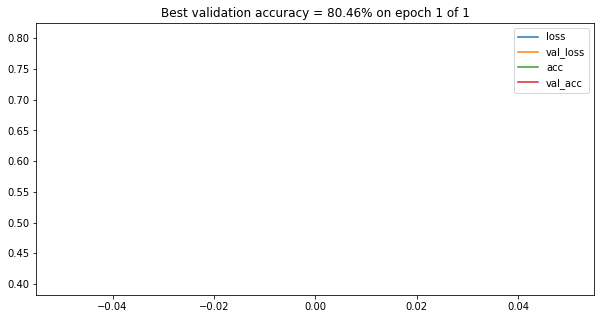

Epoch 2/10
77/78 [============================>.] - ETA: 0s - loss: 0.3853 - acc: 0.8218

In [ ]:
# Training with 10k
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)